In [1]:
import matplotlib.pyplot as plt
import numpy as np
import re
import sys

In [2]:
sys.path.append('../../..')
import utils

In [3]:
def parse_logfile_debug(logfile):
    num_rounds = {}
    with open(logfile, 'r') as f:
        current_round = 0
        round_start = False
        for line in f:
            if 'Micro-task scheduled' in line:
                if not round_start:
                    round_start = True
                    print('Round %d' % (current_round))
                match = re.search('Job ID: (\d+).*Worker type: (\w+)\tWorker ID\(s\): (.*)\tPriority', line)
                assert match is not None
                job_id = int(match.group(1))
                worker_type = match.group(2)
                worker_ids =  match.group(3)
                if job_id not in num_rounds:
                    num_rounds[job_id] = {}
                    for worker_type in ['k80', 'p100', 'v100']:
                        num_rounds[job_id][worker_type] = 0
                num_rounds[job_id][worker_type] += 1
                print('Job %d\tworker type: %s\tWorker IDs: %s' % (job_id, worker_type, worker_ids))
            elif round_start:
                current_round += 1
                print('')
                round_start = False
    
    for job_id in sorted(num_rounds.keys()):
        print('Job %d: %d K80\t%d P100\t%d V100' % (job_id, num_rounds[job_id]['k80'], num_rounds[job_id]['p100'], num_rounds[job_id]['v100']))

In [4]:
def get_jcts_from_logfile(logfile):
    jcts = {}
    with open(logfile, 'r') as f:
        collect_jcts = False
        for line in f:
            if line.strip() == 'Job completion times:':
                collect_jcts = True
                continue
            if collect_jcts:
                match = re.match('Job (\d+): (\d+\.\d+)', line.strip())
                if match is not None:
                    job_id = int(match.group(1))
                    jct = float(match.group(2))
                    jcts[job_id] = jct
                else:
                    return jcts

In [5]:
def get_cdf(data):
    """Returns the CDF of the given data.
    
       Args:
           data: A list of numerical values.
           
       Returns:
           An pair of lists (x, y) for plotting the CDF.
    """
    sorted_data = sorted(data)
    p = 100. * np.arange(len(sorted_data)) / (len(sorted_data) - 1)
    return sorted_data, p

In [6]:
jobs, arrival_times = utils.parse_trace('/Users/keshavsanthanam/workspace/gpusched/scheduler/traces/physical_cluster/minimize_makespan.trace')

In [7]:
def get_ratios(real_jcts, simulation_jcts):
    ratios = []
    for job_id in sorted(simulation_jcts.keys()):
        ratios.append(real_jcts[job_id] / simulation_jcts[job_id])
    return ratios

In [8]:
def print_sorted_ratios(ratios):
    jobs_and_ratios = []
    for i, (job, ratio) in enumerate(zip(jobs, ratios)):
        jobs_and_ratios.append((i, job.job_type, ratio))
    jobs_and_ratios.sort(key=lambda x: x[-1])
    for (job_id, job_type, ratio) in jobs_and_ratios:
        print('Job %d (%s): real / simulation: %.2fx' % (job_id, job_type, ratio))

In [9]:
def plot_ratios(ratios):
    data, p = get_cdf(ratios)
    plt.plot(data, p)
    plt.xlim(xmin=0)
    plt.xlabel('Real JCT / Simulation JCT')
    plt.ylabel('Cumulative % of Jobs')

In [10]:
def print_ratios_and_plot(policy):
    simulation_logfile = '../../../logs/physical_cluster_experiments_osdi20/%s/simulation.log' % (policy)
    real_logfile = '../../../logs/physical_cluster_experiments_osdi20/%s/server.log' % (policy)
    simulation_jcts = get_jcts_from_logfile(simulation_logfile)
    real_jcts = get_jcts_from_logfile(real_logfile)
    ratios = get_ratios(simulation_jcts, real_jcts)
    print_sorted_ratios(ratios)
    plot_ratios(ratios)

Job 64 (Recommendation (batch size 4096)): real / simulation: 0.65x
Job 30 (Recommendation (batch size 4096)): real / simulation: 0.86x
Job 21 (CycleGAN): real / simulation: 0.89x
Job 4 (ResNet-50 (batch size 128)): real / simulation: 0.95x
Job 47 (ResNet-50 (batch size 128)): real / simulation: 0.96x
Job 97 (A3C): real / simulation: 0.97x
Job 43 (LM (batch size 20)): real / simulation: 0.97x
Job 61 (LM (batch size 5)): real / simulation: 0.97x
Job 96 (Transformer (batch size 16)): real / simulation: 0.97x
Job 75 (LM (batch size 20)): real / simulation: 0.98x
Job 66 (Recommendation (batch size 2048)): real / simulation: 0.99x
Job 77 (ResNet-18 (batch size 64)): real / simulation: 0.99x
Job 37 (Transformer (batch size 64)): real / simulation: 0.99x
Job 81 (LM (batch size 5)): real / simulation: 0.99x
Job 23 (LM (batch size 20)): real / simulation: 1.00x
Job 14 (LM (batch size 10)): real / simulation: 1.00x
Job 46 (LM (batch size 10)): real / simulation: 1.00x
Job 90 (LM (batch size 20))

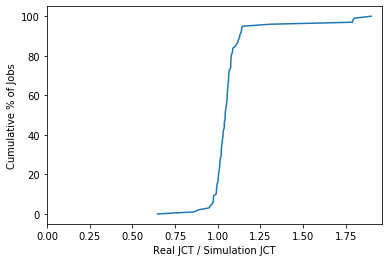

In [11]:
print_ratios_and_plot('min_total_duration')

Job 2 (Transformer (batch size 256)): real / simulation: 0.28x
Job 76 (A3C): real / simulation: 0.57x
Job 4 (ResNet-50 (batch size 128)): real / simulation: 0.78x
Job 47 (ResNet-50 (batch size 128)): real / simulation: 0.82x
Job 33 (Transformer (batch size 32)): real / simulation: 0.83x
Job 7 (Transformer (batch size 128)): real / simulation: 0.83x
Job 37 (Transformer (batch size 64)): real / simulation: 0.83x
Job 99 (LM (batch size 80)): real / simulation: 0.84x
Job 65 (Transformer (batch size 32)): real / simulation: 0.84x
Job 61 (LM (batch size 5)): real / simulation: 0.85x
Job 10 (LM (batch size 5)): real / simulation: 0.86x
Job 77 (ResNet-18 (batch size 64)): real / simulation: 0.88x
Job 98 (ResNet-18 (batch size 64)): real / simulation: 0.88x
Job 20 (LM (batch size 80)): real / simulation: 0.89x
Job 90 (LM (batch size 20)): real / simulation: 0.89x
Job 8 (CycleGAN): real / simulation: 0.89x
Job 43 (LM (batch size 20)): real / simulation: 0.90x
Job 25 (CycleGAN): real / simulation

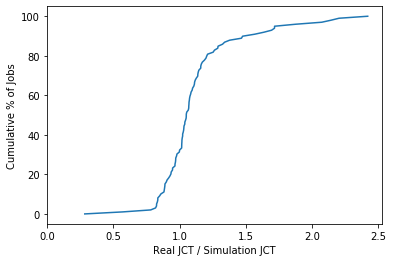

In [12]:
print_ratios_and_plot('gandiva')